In [15]:
import MGBlurr.blurring as blur
import MGTomo.functions as fcts
from MGTomo.utils import mylog, mydiv
from MGTomo.optimize import armijo_linesearch, box_bounds
from MGTomo.gridop import RBox as R, PBox as P

from skimage import data
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
from torch.linalg import matrix_norm

import time

In [16]:
N = 1023
max_levels = 4
maxIter = [1,4,16,32,64]
kernel_size = 33
sigma = 10

# load image
x_orig = data.camera()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

A = [blur.GaussianBlurOperator(N, kernel_size, sigma)]
b = [A[0](x_torch)]

fine_dim = N
for i in range(1, max_levels+1):
    coarse_dim = blur.reduce_dim(fine_dim)
    A.append(blur.GaussianBlurOperator(coarse_dim, kernel_size, sigma))
    rhs = resize(b[-1].detach().numpy(), (coarse_dim, coarse_dim), anti_aliasing=False)
    b.append(torch.tensor(rhs, requires_grad=True)) #maybe use a different way to define bH
    fine_dim = coarse_dim
    

In [17]:
def kl_distance(x: torch.tensor, A, b: torch.tensor):
    ax = A(x).double()
    #ab = torch.divide(ax, b)
    ab = mydiv(ax,b)
    
    erg = ax * mylog(ab) + b - ax
    fx = torch.sum( erg[b > 0.] ) + 0.5*torch.sum(ax[b == 0.]**2)
    #fx = torch.sum(erg[b > 0.])
    assert fx >= 0, fx
    #assert fx >= 0, 'kl distance error: output is negative.'
    return fx.requires_grad_(True)

In [18]:
tau = 0.5 * (max_levels+1)
fh = lambda x: kl_distance(x, A[0], b[0])
P_inf = 1

In [19]:
fh(torch.ones_like(x_torch))

tensor(507555.7935, dtype=torch.float64, grad_fn=<AddBackward0>)

In [20]:
b[0]

tensor([[0.7824, 0.7824, 0.7824,  ..., 0.7458, 0.7457, 0.7457],
        [0.7824, 0.7824, 0.7824,  ..., 0.7458, 0.7458, 0.7458],
        [0.7824, 0.7824, 0.7824,  ..., 0.7458, 0.7458, 0.7458],
        ...,
        [0.0975, 0.0975, 0.0975,  ..., 0.5698, 0.5694, 0.5693],
        [0.0975, 0.0975, 0.0975,  ..., 0.5690, 0.5686, 0.5685],
        [0.0975, 0.0975, 0.0975,  ..., 0.5687, 0.5684, 0.5682]],
       dtype=torch.float64, grad_fn=<SqueezeBackward1>)

In [21]:
A[0](x_torch)

tensor([[0.7824, 0.7824, 0.7824,  ..., 0.7458, 0.7457, 0.7457],
        [0.7824, 0.7824, 0.7824,  ..., 0.7458, 0.7458, 0.7458],
        [0.7824, 0.7824, 0.7824,  ..., 0.7458, 0.7458, 0.7458],
        ...,
        [0.0975, 0.0975, 0.0975,  ..., 0.5698, 0.5694, 0.5693],
        [0.0975, 0.0975, 0.0975,  ..., 0.5690, 0.5686, 0.5685],
        [0.0975, 0.0975, 0.0975,  ..., 0.5687, 0.5684, 0.5682]],
       dtype=torch.float64, grad_fn=<SqueezeBackward1>)

In [22]:
def coarse_condition_v2(y, grad_y, kappa, eta, y_last = None):
    gcond = (matrix_norm(R(grad_y)) >= kappa * matrix_norm(grad_y))
    if gcond:
        if y_last is not None:
            y_diff_norm = matrix_norm(y_last - y)
            y_norm = matrix_norm(y)
            return (y_diff_norm >= eta * y_norm)
        return True
    else:
        return False

In [23]:
def MLO_box(fh, y, lh, uh, last_pts: list, l=0, kappa = 0.49, eps = 0.001):
    x = R(y).detach().requires_grad_(True)
    y0, x0 = y, x.clone().detach().requires_grad_(True)
    
    fhy0 = fh(y0)
    fhy0.backward(retain_graph = True)
    grad_fhy0 = y0.grad.clone()
    y0.grad.zero_()
    
    if coarse_condition_v2(y, grad_fhy0, kappa, eps, last_pts[l]):
    #if coarse_condition_v3(grad_fhy0, kappa, eps):
        print(l, ' : coarse correction activated')
        last_pts[l] = y0.clone().detach()
    
        fH = lambda x: kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad.zero_()

        kappa = R(grad_fhy0) - grad_fHx0

        psi = lambda x: fH(x) + torch.sum(kappa * x)
        lH, uH = box_bounds(y0, x, P_inf, lh, uh)

        logvH_new = mylog(x - lH) - mylog(uH - x)
        for i in range(maxIter[l]):
            x.retain_grad()
            val, logvH_new = fcts.BSMART_general(psi, x, logvH_new, tau[l+1], lH, uH)
            x = val.clone().detach().requires_grad_(True)
            
        if l < max_levels-1:
            x, last_pts = MLO_box(psi, x,lH, uH, last_pts, l+1)

        d = P(x-x0)
        y, a = armijo_linesearch(fh, y0, d)
    else: 
        print(l, ' : coarse correction not activated')

    logvh_new = mylog(y - lh) - mylog(uh - y)
    
    for i in range(maxIter[l]):
        y.retain_grad()
        yval, logvh_new = fcts.BSMART_general(fh, y, logvh_new, tau[l], lh, uh)
        y = yval.clone().detach().requires_grad_(True)
    return y, last_pts

In [24]:
w0 = torch.ones(N, N, requires_grad = True)*0.5
lh = torch.zeros_like(w0)
uh = torch.ones_like(w0)

rel_f_err_SL = []
rel_f_err_SL.append((matrix_norm(w0 - x_torch)/matrix_norm(w0)).item())

iteration_times_SL = []
iteration_times_SL.append(0)
overall_start_time_SL = time.time()  # Start overall timing

logv_new = (w0 - lh) / (uh - w0)

for i in range(100):
    iteration_start_time_SL = time.time()  # Start timing for this iteration
    
    val, logv_new = fcts.BSMART_general(fh, w0, logv_new, 0.5, lh, uh)
    
    iteration_end_time_SL = time.time()  # End timing for this iteration
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    
    iteration_times_SL.append(iteration_time_SL)
    w0 = val.clone().detach().requires_grad_(True)
    rel_f_err_SL.append((matrix_norm(w0-x_torch)/matrix_norm(w0)).item())
    
    print(f"Iteration {i}: {fh(w0)} - Time: {iteration_time_SL:.6f} seconds")

overall_end_time_SL = time.time()  # End overall timing
overall_time_SL = overall_end_time_SL - overall_start_time_SL  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_SL:.6f} seconds")
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]


Iteration 0: 157409.3036761423 - Time: 5.926351 seconds
Iteration 1: 60742.58748701948 - Time: 5.831875 seconds
Iteration 2: 22843.710251057375 - Time: 5.816020 seconds
Iteration 3: 9648.30804231229 - Time: 5.872619 seconds
Iteration 4: 4715.443909799857 - Time: 5.837152 seconds
Iteration 5: 2610.299974096822 - Time: 5.756319 seconds
Iteration 6: 1585.0471389212785 - Time: 5.781078 seconds
Iteration 7: 1029.3274729151651 - Time: 5.833287 seconds
Iteration 8: 703.7955885220867 - Time: 6.093048 seconds
Iteration 9: 502.4690565253238 - Time: 5.902988 seconds
Iteration 10: 372.9539613149653 - Time: 5.992369 seconds
Iteration 11: 286.9700969164711 - Time: 5.855796 seconds
Iteration 12: 228.25711913323354 - Time: 5.825049 seconds
Iteration 13: 187.0558290756972 - Time: 5.816430 seconds
Iteration 14: 157.3362471879309 - Time: 5.817905 seconds
Iteration 15: 135.2945620250598 - Time: 5.860111 seconds
Iteration 16: 118.49122838499973 - Time: 5.821100 seconds
Iteration 17: 105.3385295697217 - Tim

KeyboardInterrupt: 

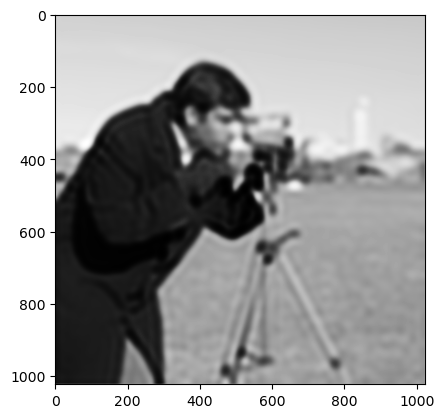

In [25]:
plt.imshow(w0.detach().numpy(), cmap = 'gray')

In [26]:
z0 = torch.ones(N, N) * 0.5
z0.requires_grad_(True)
last_pts = [None]*(max_levels+1)

lh = torch.zeros_like(z0)
uh = torch.ones_like(z0)

rel_f_err = []
rel_f_err.append((matrix_norm(z0 - x_torch)/matrix_norm(z0)).item())

iteration_times_ML = []
iteration_times_ML.append(0)
overall_start_time_ML = time.time()

for i in range(100):
    iteration_start_time_ML = time.time()
    
    val, ylast = MLO_box(fh, z0, lh, uh, last_pts)
    iteration_end_time_ML = time.time()
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML

    iteration_times_ML.append(iteration_time_ML)
    z0 = val.clone().detach().requires_grad_(True)
    rel_f_err.append((matrix_norm(z0-x_torch)/matrix_norm(z0)).item())
    
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time_ML:.6f} seconds")

overall_end_time_ML = time.time()  # End overall timing
overall_time_ML = overall_end_time_ML - overall_start_time_ML  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

0  : coarse correction activated


TypeError: 'float' object is not subscriptable